<a href="https://colab.research.google.com/github/aadsouza/ubc_econ_323_final_project_submission/blob/master/econ_323_final_project_aa_dsouza_gen_lang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gendered Language on University Subreddits - ECON 323 Final Project



> **Author**
- [Amedeus A. Dsouza](https://sites.google.com/view/aadsouza)

In this notebook, we seek to understand university culture through comments made on the social media platform Reddit by focusing our analysis on university subreddits which are frequently used by prospective students and current students at both the undergraduate as well as the graduate level. Alice H. Wu (2018) seeks to understand culture in academia through the Economics Job Market Rumors forum. Both Reddit as well as Economics Job Market Rumors offer users a degree of anonymity. Note that therefore, both platforms may be used by people outside the academic communities as well. While Wu (2018) suggests that Economics Job Market Rumors was initially created for discussions surrounding job market placements, interviews, and outcomes, Wu (2018) seeks to understand if there is a distinct stereotypical culture. The author finds that the words "hotter", "pregnant", and "plow" are the most predictive of a post being classified as female while "homo", "testosterone", and "chapters" are predictive of a post being classified as male. Beyond the heteronormativity and misogyny that emerge from the word list, Wu (2018) finds professional words such as "supervisor" and "adviser" are predictive of a post discussing a male. We apply the same lasso-logistic model and use the similar methods as Wu (2018) to understand if that culture permeates social media forums used by members of the academic community. We are aware that as Wu (2018) discusses, both Reddit as well as Economics Job Market Rumors are moderated communities. Posts that do not meet the respective set of community guidelines may be subject to action by moderators including deletion of the post. Therefore our analysis is limited in that the comments in the dataset that we extract are not necessarily an unbiased reflection of university culture. Also our sample is certainly not random. Not every student and faculty at universities use their respective university subreddit, and subreddits are rarely if ever the primary means of university-level communication.

In [ ]:
#Install on colab or as necessary
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes psaw pyarrow

In [ ]:
#Not all packages imported were necessarily used in the analysis
import pandas as pd
import numpy as np
import patsy
import json
import os
from bs4 import BeautifulSoup
import time
import psaw
from google.colab import files
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();
import pyarrow.feather
import scipy
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection
from sklearn import linear_model
from sklearn.inspection import plot_partial_dependence
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Using PSAW to get data

In this section, we leverage [PSAW](https://github.com/dmarx/psaw) which is a wrapper for [Pushshift API](https://github.com/pushshift/api) to build a dataset of less than 3 million Reddit comments made on the subreddits of universities with economics departments in top 35 institutions as of March 2020 according to rankings published by RePEc. You can find the ranking list [here](https://ideas.repec.org/top/top.econdept.html). We note first that the choice of ranking list to use for the analysis was indeed arbitrary. For this analysis we focused on the top 35 institutions. We could not include Paris School of Economics, Toulouse School of Economics, Barcelona Graduate School of Economics, Tilburg University, Graduate School of Business - Columbia University (Columbia University has been entered once). We asked for up to 500,000 comments per subreddit. We wish to emphasize that we do not have 500,000 comments for each subreddit and that some subreddits would be under-represented in the analysis unless weights are attached.

We strongly recommend running this section in a separate session in order to minimize burdening servers and to efficiently use RAM. We ran this section on Tuesday, April 14 2020. The analysis in this notebook shall be based on data collected on that day.

In [ ]:
api = psaw.PushshiftAPI()

harvardgen = api.search_comments(subreddit = "harvard", limit = 500000)
harvarddata = pd.DataFrame([i.d_ for i in harvardgen])

mitgen = api.search_comments(subreddit = "mit", limit = 500000)
mitdata = pd.DataFrame([i.d_ for i in mitgen])

berkeleygen = api.search_comments(subreddit = "berkeley", limit = 500000)
berkeleydata = pd.DataFrame([i.d_ for i in berkeleygen])

uchicagogen = api.search_comments(subreddit = "uchicago", limit = 500000)
uchicagodata = pd.DataFrame([i.d_ for i in uchicagogen])

princetongen = api.search_comments(subreddit = "princeton", limit = 500000)
princetondata = pd.DataFrame([i.d_ for i in princetongen])

stanfordgen = api.search_comments(subreddit = "stanford", limit = 500000)
stanforddata = pd.DataFrame([i.d_ for i in stanfordgen])

oxfordunigen = api.search_comments(subreddit = "oxforduni", limit = 500000)
oxfordunidata = pd.DataFrame([i.d_ for i in oxfordunigen])

columbiagen = api.search_comments(subreddit = "columbia", limit = 500000)
columbiadata = pd.DataFrame([i.d_ for i in columbiagen])

brownugen = api.search_comments(subreddit = "brownu", limit = 500000)
brownudata = pd.DataFrame([i.d_ for i in brownugen])

nyugen = api.search_comments(subreddit = "nyu", limit = 500000)
nyudata = pd.DataFrame([i.d_ for i in nyugen])

yalegen = api.search_comments(subreddit = "yale", limit = 500000)
yaledata = pd.DataFrame([i.d_ for i in yalegen])

bostonugen = api.search_comments(subreddit = "bostonu", limit = 500000)
bostonudata = pd.DataFrame([i.d_ for i in bostonugen])

dartmouthgen = api.search_comments(subreddit = "dartmouth", limit = 500000)
dartmouthdata = pd.DataFrame([i.d_ for i in dartmouthgen])

upenngen = api.search_comments(subreddit = "upenn", limit = 500000)
upenndata = pd.DataFrame([i.d_ for i in upenngen])

ucsdgen = api.search_comments(subreddit = "ucsd", limit = 500000)
ucsddata = pd.DataFrame([i.d_ for i in ucsdgen])

uclgen = api.search_comments(subreddit = "ucl", limit = 500000)
ucldata = pd.DataFrame([i.d_ for i in uclgen])

uclagen = api.search_comments(subreddit = "ucla", limit = 500000)
ucladata = pd.DataFrame([i.d_ for i in uclagen])

northwesterngen = api.search_comments(subreddit = "northwestern", limit = 500000)
northwesterndata = pd.DataFrame([i.d_ for i in northwesterngen])

uwmadisongen = api.search_comments(subreddit = "uwmadison", limit = 500000)
uwmadisondata = pd.DataFrame([i.d_ for i in uwmadisongen])

thelsegen = api.search_comments(subreddit = "thelse", limit = 500000)
thelsedata = pd.DataFrame([i.d_ for i in thelsegen])

msugen = api.search_comments(subreddit = "msu", limit = 500000)
msudata = pd.DataFrame([i.d_ for i in msugen])

uofmgen = api.search_comments(subreddit = "uofm", limit = 500000)
uofmdata = pd.DataFrame([i.d_ for i in uofmgen])

ucdavisgen = api.search_comments(subreddit = "ucdavis", limit = 500000)
ucdavisdata = pd.DataFrame([i.d_ for i in ucdavisgen])

bostoncollegegen = api.search_comments(subreddit = "bostoncollege", limit = 500000)
bostoncollegedata = pd.DataFrame([i.d_ for i in bostoncollegegen])

ubcgen = api.search_comments(subreddit = "ubc", limit = 500000)
ubcdata = pd.DataFrame([i.d_ for i in ubcgen])

georgetowngen = api.search_comments(subreddit = "georgetown", limit = 500000)
georgetowndata = pd.DataFrame([i.d_ for i in georgetowngen])

uscgen = api.search_comments(subreddit = "usc", limit = 500000)
uscdata = pd.DataFrame([i.d_ for i in uscgen])

universityofwarwickgen = api.search_comments(subreddit = "universityofwarwick", limit = 500000)
universityofwarwickdata = pd.DataFrame([i.d_ for i in universityofwarwickgen])

uoftgen = api.search_comments(subreddit = "uoft", limit = 500000)
uoftdata = pd.DataFrame([i.d_ for i in uoftgen])

uongen = api.search_comments(subreddit = "uon", limit = 500000)
uondata = pd.DataFrame([i.d_ for i in uongen])


unidata = pd.concat([harvarddata, mitdata, berkeleydata, uchicagodata, princetondata, stanforddata, oxfordunidata, columbiadata, brownudata, nyudata, yaledata, bostonudata, dartmouthdata, upenndata, ucsddata, ucldata, ucladata, northwesterndata, uwmadisondata, thelsedata, msudata, uofmdata, ucdavisdata, bostoncollegedata, ubcdata, georgetowndata, uscdata, universityofwarwickdata, uoftdata, uondata])
unibodydata = unidata.loc[:,["body"]]

In [ ]:
unidata = unidata.reset_index()
unidata.to_csv("unidata.csv")

## Understanding the data

After we download the data we collected in the previous section we import it for analysis.

In [ ]:
#Set directory as necessary
from google.colab import drive
drive.mount("/content/drive")

unidata = pd.read_csv("/content/drive/My Drive/unidata.csv")
unidata.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,3,5,6,7,8,10,11,12,13,14,15,19,21,23,24,26,27,29,30,34,37,38,39,43,44,45,49,50,51,52,53,54,55,56) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,index,all_awardings,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_patreon_flair,author_premium,awarders,body,collapsed_because_crowd_control,created_utc,gildings,id,is_submitter,link_id,locked,no_follow,parent_id,permalink,retrieved_on,score,send_replies,stickied,subreddit,subreddit_id,total_awards_received,treatment_tags,created,edited,distinguished,author_cakeday,steward_reports,updated_utc,gilded,author_created_utc,can_gild,collapsed,collapsed_reason,controversiality,nest_level,reply_delay,subreddit_name_prefixed,subreddit_type,user_removed,mod_removed,removal_reason,score_hidden,rte_mode,permalink_url
0,0,0.0,[],NaN,everythingharam,NaN,NaN,[],NaN,NaN,NaN,text,t2_26tskkl,False,False,[],This is an interesting comment. Care to elabor...,NaN,1.586872e+09,{},fndkuxz,True,t3_g1196c,False,True,t1_fndkrbe,/r/Harvard/comments/g1196c/college_is_making_m...,1.5869e+09,4.0,True,False,Harvard,t5_2qkkm,0.0,[],1.586872e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,[],NaN,DakwonBrown,NaN,NaN,[],NaN,NaN,NaN,text,t2_657iry16,False,False,[],Are you a director in your life or just an actor?,NaN,1.586872e+09,{},fndkrbe,False,t3_g1196c,False,True,t3_g1196c,/r/Harvard/comments/g1196c/college_is_making_m...,1.5869e+09,6.0,True,False,Harvard,t5_2qkkm,0.0,[],1.586872e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.0,[],NaN,coolcatsarecold,NaN,NaN,[],NaN,NaN,NaN,text,t2_7rk21,False,False,[],You over explaining my guy,NaN,1.586872e+09,{},fndkoth,False,t3_g08gzx,False,True,t1_fndizbt,/r/Harvard/comments/g08gzx/the_quad_only_has_g...,1.5869e+09,0.0,True,False,Harvard,t5_2qkkm,0.0,[],1.586872e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.0,[],NaN,Thoreau80,NaN,NaN,[],NaN,NaN,NaN,text,t2_tekuu,False,False,[],So do something else. Do college when you act...,NaN,1.586872e+09,{},fndjxhl,False,t3_g1196c,False,True,t3_g1196c,/r/Harvard/comments/g1196c/college_is_making_m...,1.5869e+09,-1.0,True,False,Harvard,t5_2qkkm,0.0,[],1.586872e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4.0,[],NaN,starfleet_rambo,NaN,NaN,[],NaN,NaN,NaN,text,t2_2pzsvi08,False,False,[],I could say MD but either way the quad is clos...,NaN,1.586871e+09,{},fndizbt,False,t3_g08gzx,False,True,t1_fnd5k6d,/r/Harvard/comments/g08gzx/the_quad_only_has_g...,1.5869e+09,1.0,True,False,Harvard,t5_2qkkm,0.0,[],1.586871e+09,1.586876e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We select columns that we believe will be useful for the analysis: the name of the author that made the comment, the body of the comment, the score of the comment and the subreddit the comment was made on.

In [ ]:
uniuseful = unidata[["author", "body", "score", "subreddit"]]
uniuseful.head()

,author,body,score,subreddit
0,everythingharam,This is an interesting comment. Care to elabor...,4.0,Harvard
1,DakwonBrown,Are you a director in your life or just an actor?,6.0,Harvard
2,coolcatsarecold,You over explaining my guy,0.0,Harvard
3,Thoreau80,So do something else. Do college when you act...,-1.0,Harvard
4,starfleet_rambo,I could say MD but either way the quad is clos...,1.0,Harvard


In [ ]:
uniuseful = uniuseful.rename(columns={"body": "comment_body"}) #one of the tokens is "body"

We list the unique subreddits in the dataset and create a visualization that shows the number of comments in the dataset by subreddit.

In [ ]:
uniuseful.subreddit.unique()

array(['Harvard', 'mit', 'berkeley', nan, '3.0', '25238.0', '2.0', '1.0',
       '4.0', 'uchicago', 'princeton', 'stanford', 'oxforduni',
       'columbia', 'BrownU', 'nyu', 'yale', 'BostonU', 'dartmouth',
       'UPenn', 'UCSD', 'UCL', 'ucla', 'Northwestern', 'UWMadison',
       'TheLse', 'msu', '902.0', 'uofm', 'UCDavis', 'bostoncollege',
       'UBC', 'georgetown', 'USC', 'UniversityOfWarwick', 'UofT', 'UoN'],
      dtype=object)

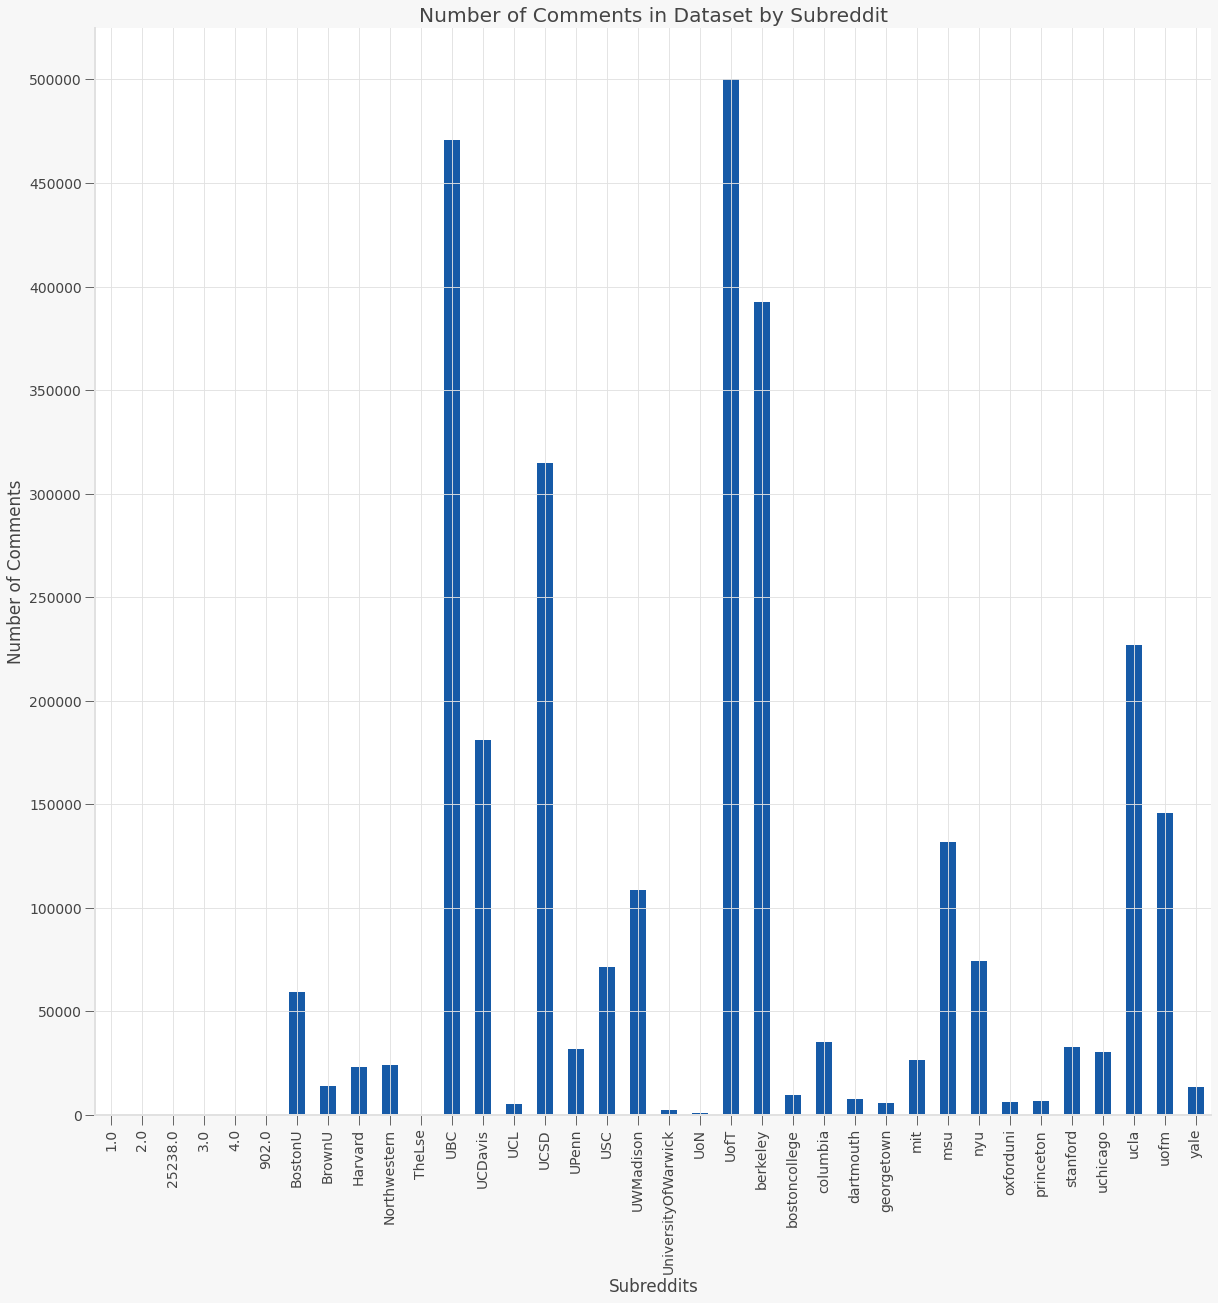

In [ ]:
fig, ax = plt.subplots(figsize = (20, 20))
groupuni = uniuseful.groupby("subreddit").count()["comment_body"]
groupuni.plot.bar(ax = ax)

ax.set_ylabel("Number of Comments")
ax.set_xlabel("Subreddits")
ax.set_title("Number of Comments in Dataset by Subreddit")
ax.set_facecolor("white")
y_ticks = np.arange(0, 550000, 50000)
ax.set_yticks(y_ticks)

We ensure that all the comments are strings. We note that as of now urls are included in the comments. We intend on using "regular expression" to get rid of the urls. We convert all the strings to lowercase.

In [ ]:
uniuseful["comment_body"] = uniuseful["comment_body"].apply(str) #convert all text in body to string

#note urls included. FIXME use "regular expression" to get rid of urls.

uniuseful = uniuseful.applymap(lambda i:i.lower() if type(i) == str else i) #lowercase strings


## Applying model developed in Wu (2018)

In this section, the crux of our analysis, we apply the model developed by Alice H. Wu (2018) to our dataset of Reddit comments. Wu (2018) studied posts on the Economics Job Market Rumors forum. Among other things, Wu (2018) runs a lasso logistic regression model in order to find the words that are predictive of a post being classified as a female or male post. The author classifies posts as female or male based on classifiers that they develop from a list of the ten thousand most frequent words in the posts. Our analysis here is based on Wu (2018) where we develop a similar (if not the same) set up and model on our dataset of Reddit comments. 

As does Wu (2018) we find the most frequent ten thousand words in the comments. We choose not to remove stopwords as preserving pronouns among other stopwords is important for classification.

In [ ]:
vectorizer = CountVectorizer(max_features = 10000) 
X = vectorizer.fit_transform(uniuseful.comment_body)

Here $X$ is a sparse matrix of word counts such that the rows of $X$ are the comments and the columns of $X$ are the frequent ten thousand words. Therefore each item in cell $(x, y)$ is the count of the word associated with column $y$ in comment associated with row $x$.

In [ ]:
X.shape

(2953040, 10000)

In [ ]:
vocab = dict(vectorizer.vocabulary_) #dictionary of vocabulary
vocab = pd.Series(vocab)
vocab = vocab.to_frame()

In [ ]:
vocab.reset_index(level=0, inplace=True)

In [ ]:
vocab = vocab.rename(columns = {"index": "word", 0: "position_in_sparse_matrix"})

We create a dataframe of the identified frequent words as measured by word count. This dataframe "vocab" includes the word and the position of the word in the sparse matrix $X$. We note that the positions of the words in the sparse matrix $X$ are arranged alpha-numerically (alphabetically with numbers before words).

In [ ]:
vocab.head()

,word,position_in_sparse_matrix
0,this,9000
1,is,5004
2,an,808
3,interesting,4916
4,comment,2129


We manually go through the vocab dataframe and as does Wu (2018) we identify candidate words that we use as classifiers. These include pronouns, common identifiers, and names commonly attributed to the genders. There is significant overlap in the words Wu (2018) uses as classifiers and us but differences still emerge due to differences between the top ten thousand words in the Economics Job Market Rumors forum dataset and the top ten thousand words in the Reddit comment dataset.

In [ ]:
#manually go through vocab and find words that can be used as classifiers
female_classifier_list = [#Pronouns
                          "her",
                          "herself",
                          "she",
                          "shes",
                          #Identifiers
                          "daughter",
                          "female",
                          "females",
                          "gf",
                          "girl",
                          "girlfriend",
                          "girls",
                          "ladies",
                          "lady",
                          "mom",
                          "mommy",
                          "mother",
                          "sister",
                          "sisters",
                          "wife",
                          "woman",
                          "women",
                          #Names
                          "anne",
                          "barbara",
                          "hillary",
                          "katehi",
                          "karen",
                          "liz",
                          "marina",
                          "mary",
                          "monica"
                          ]

male_classifier_list = [#Pronouns
                        "he",
                        "hes",
                        "him",
                        "himself",
                        "his",
                        #Identifiers
                        "boy",
                        "boyfriend",
                        "boys",
                        "bro",
                        "bros",
                        "brother",
                        "brothers",
                        "bruh",
                        "dad",
                        "daddy",
                        "dude",
                        "dudes",
                        "father",
                        "guys",
                        "husband",
                        "male",
                        "males",
                        "man",
                        "men",
                        "mr",
                        "son",
                        "uncle",
                        #Names
                        "adam",
                        "adams",
                        "albert", 
                        "alex", 
                        "alfonso", 
                        "andrew", 
                        "anthony",
                        "ben",
                        "bernie", 
                        "bob",
                        "bradley",
                        "brian", 
                        "brody",
                        "chris",
                        "charles",
                        "dan", 
                        "daniel", 
                        "dave", 
                        "david", 
                        "donald", 
                        "doug", 
                        "drake", 
                        "durant", 
                        "dwight",
                        "eric", 
                        "evans",
                        "gary",
                        "gateman",
                        "george", 
                        "gordon",
                        "gregor",
                        "harry", 
                        "jack", 
                        "james", 
                        "jay", 
                        "jeff",
                        "jerry",
                        "jim", 
                        "jimmy",
                        "john", 
                        "johnny",
                        "josh", 
                        "justin",
                        "kevin",
                        "larry", 
                        "lawrence",
                        "lorenzo", 
                        "louis",
                        "martin",  
                        "matt",  
                        "michael", 
                        "mike",
                        "milo",
                        "nick",
                        "ono",
                        "owen", 
                        "paul",
                        "pete",
                        "peter", 
                        "ralph", 
                        "ralphs", 
                        "richard", 
                        "robert",
                        "ron",
                        "ross",
                        "ryan",
                        "santa",
                        "sean",
                        "simon", 
                        "spencer",
                        "stephen", 
                        "steve", 
                        "stewart", 
                        "tom",
                        "thomas", 
                        "william", 
                        "wilson"
                        ]
all_classifier_list = female_classifier_list + male_classifier_list

As does Wu (2018), we create a column Female which takes the value of 1 if it includes a strictly postiive number of female classifiers,  0 if it includes a strictly positive number of male classifiers, else is null.

In [ ]:
vocab["female"] = np.nan #add new column female = 1 if female classifier, female = 0 if male classifier, female = np.nan otherwise

for i in vocab.index:
  if vocab.word[i] in female_classifier_list:
    vocab.female[i] = 1
  elif vocab.word[i] in male_classifier_list:
    vocab.female[i] = 0
  else: vocab.female[i] = np.nan 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
female_words = vocab.loc[vocab["female"] == 1] #find position in sparse matrix of female classifiers

In [ ]:
male_words = vocab.loc[vocab["female"] == 0] #find position in sparse matrix of male classifiers

In [ ]:
female_pos_list = list(female_words.position_in_sparse_matrix) #create list of positions of female classifiers

In [ ]:
male_pos_list = list(male_words.position_in_sparse_matrix) #create list of positions of male classifiers

In [ ]:
female_post_word_count = X[:, female_pos_list].sum(axis = 1) #matrix of how many female classifiers are in each post

In [ ]:
male_post_word_count = X[:, male_pos_list].sum(axis = 1) #matrix of how many male classifiers are in each post

In [ ]:
female_post_word_count_data = pd.DataFrame(female_post_word_count) 

In [ ]:
female_post_word_count_data = female_post_word_count_data.rename(columns = {0: "female_post_word_count_col"})

In [ ]:
male_post_word_count_data = pd.DataFrame(male_post_word_count)

In [ ]:
male_post_word_count_data = male_post_word_count_data.rename(columns = {0: "male_post_word_count_col"})

In [ ]:
uniuseful_w_fem_mal_counts = pd.concat([uniuseful, female_post_word_count_data, male_post_word_count_data], axis = 1)

In [ ]:
uniuseful_w_fem_mal_counts["post_incl_fem_class"] = uniuseful_w_fem_mal_counts["female_post_word_count_col"] > 0 #create column of booleans such that True if there is a strictly positive number of female classifiers in the post else False

In [ ]:
uniuseful_w_fem_mal_counts["post_incl_mal_class"] = uniuseful_w_fem_mal_counts["male_post_word_count_col"] > 0 #create column of booleans such that True if there is a strictly positive number of male classifiers in the post else False

In [ ]:
uniuseful_w_fem_mal_counts["post_gendered_lang"] = (uniuseful_w_fem_mal_counts["post_incl_fem_class"] == True) | (uniuseful_w_fem_mal_counts["post_incl_mal_class"] == True)  #create column of booleans such that True if includes a gender classifier else False

Therefore, based on the set up of Wu (2018), we have a dataset of Reddit comments that includes the author of the comments ("author"), the body of the comments ("comment_body"), the score of the comments ("score"), the word count of words in the list of female classifiers in each comment("female_post_word_count_col"), the word count of words in the list of male classifiers in each comment("male_post_word_count_col"), a column of booleans indicating if the comment includes a strictly positive word count of female classifiers ("post_incl_fem_class"), a column of booleans indicating if the comment includes a strictly positive word count of male classifiers ("post_incl_mal_class"), a column of booleans indicating if the comment includes "gendered language" i.e. a strictly positive word count of female classifiers OR a strictly positive word count of male classifiers ("post_gendered_lang").

In [ ]:
uniuseful_w_fem_mal_counts.head()

,author,comment_body,score,subreddit,female_post_word_count_col,male_post_word_count_col,post_incl_fem_class,post_incl_mal_class,post_gendered_lang
0,everythingharam,this is an interesting comment. care to elabor...,4.0,harvard,0,0,False,False,False
1,dakwonbrown,are you a director in your life or just an actor?,6.0,harvard,0,0,False,False,False
2,coolcatsarecold,you over explaining my guy,0.0,harvard,0,0,False,False,False
3,thoreau80,so do something else. do college when you act...,-1.0,harvard,0,0,False,False,False
4,starfleet_rambo,i could say md but either way the quad is clos...,1.0,harvard,0,0,False,False,False


In [ ]:
uniuseful_gendered = uniuseful_w_fem_mal_counts.loc[uniuseful_w_fem_mal_counts["post_gendered_lang"] == True] #dataframe of posts that include strictly positive gender classifier

In [ ]:
uniuseful_gendered["post_incl_only_fem_class"] = (uniuseful_gendered["post_incl_fem_class"] == True) & (uniuseful_gendered["post_incl_mal_class"] == False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
uniuseful_gendered["post_incl_only_mal_class"] = (uniuseful_gendered["post_incl_fem_class"] == False) & (uniuseful_gendered["post_incl_mal_class"] == True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
uniuseful_gendered["post_incl_both_class"] = (uniuseful_gendered["post_incl_fem_class"] == True) & (uniuseful_gendered["post_incl_mal_class"] == True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
uniuseful_gendered["post_incl_only_one_class"] = (uniuseful_gendered["post_incl_only_fem_class"] == True) | (uniuseful_gendered["post_incl_only_mal_class"] == True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
uniuseful_gendered["post_incl_fem_class_int"] = uniuseful_gendered.post_incl_fem_class.astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


As does Wu (2018) we create a dataframe of the subset of Reddit comments that include gendered language that is a strictly positive word count of gender classifiers where in addition to the aforementioned columns, we also include a column of booleans indicating if the comments included only a strictly positive word count of female classifiers ("post_incl_only_fem_class"), a column of booleans indicating if the comments included only a strictly positive word count of male classifiers ("post_incl_only_mal_class"), a column of booleans indicating if the comments included a strictly positive word count of both female and male classifiers ("post_incl_both_class"),a column of booleans indicating fi the comments included a strictly positive word count of either female or male classifiers but not both ("post_incl_only_one_class"), a column of "post_incl_only_fem_class" as an integer i.e. True = 1, False = 0 ("post_incl_only_fem_class_int").

In [ ]:
uniuseful_gendered.head()

,author,comment_body,score,subreddit,female_post_word_count_col,male_post_word_count_col,post_incl_fem_class,post_incl_mal_class,post_gendered_lang,post_incl_only_fem_class,post_incl_only_mal_class,post_incl_both_class,post_incl_only_one_class,post_incl_fem_class_int
7,throwaway_he1p,"dude, your post history is so weird. stop adve...",1.0,harvard,0,1,False,True,True,False,True,False,True,0
10,coolcatsarecold,"man, if you wanted to give an example of why t...",0.0,harvard,0,1,False,True,True,False,True,False,True,0
17,midwest88,your story is either inaccurate or you're tell...,1.0,harvard,0,2,False,True,True,False,True,False,True,0
19,bigred1636,this is an ad hominem attack on people who don...,1.0,harvard,4,1,True,True,True,False,False,True,False,1
21,zan_jr,"i think she means that by not endorsing biden,...",5.0,harvard,1,1,True,True,True,False,False,True,False,1


As does Wu (2018), we identify the rows of the sparse matrix $X$ that correspond to comments that include a strictly positive word count of gender classifiers.

In [ ]:
X_gendered = X[list(uniuseful_gendered.index), :]

Next as does Wu (2018) we split the comments that include either a female or male classifier but not both into a training and testing set down a 75-25 split i.e. 75% of comments that include either a female or male classifier but not both are in the training set and 25% of comments that include either a female or male classifier but not both are in the testing set.

In [ ]:
train_one_class, test_one_class = model_selection.train_test_split(uniuseful_gendered.loc[uniuseful_gendered["post_incl_only_one_class"] == True]) #split dataset with either male or female classifiers but not both into training and testing

As does Wu (2018) we create another testing set of comments that include both female and male classifiers. The purpose of this is to reclassify these posts as female or male posts. Wu (2018) uses a threshold based on the optimal p-value in order to do that classification.

In [ ]:
test_both_class = uniuseful_gendered.loc[uniuseful_gendered["post_incl_both_class"] == True]

We find the rows in the sparse matrix $X$ that correspond to the rows subsetted to be in the training set.

In [ ]:
X_train_one_class = X[list(train_one_class.index), :]

We find the rows in the sparse matrix $X$ that correspond to the rows subsetted to be in the first of the two testing sets we mentioned above.

In [ ]:
X_test_one_class = X[list(test_one_class.index), :]

We find the rows in the sparse matrix $X$ that correspond to the rows subsetted to be in the testing set that need to be reclassified as female/male posts.

In [ ]:
X_test_both_class = X[list(test_both_class.index), :]

We find the words in the dataframe of the ten thousand highest word counts that are not used as classifiers.

In [ ]:
non_classifier_words = vocab.loc[vocab["female"].isnull()]

We find their positions in the sparse matrix $X$.

In [ ]:
non_classifier_pos_list = list(non_classifier_words.position_in_sparse_matrix)

We create a sparse matrix $X\_train\_one\_class\_non\_classifier$ such that the rows are comments that include a strictly positive word count of gender classifiers and are in the training set and the columns are words that are not used as classifiers; likewise for the two testing subsets.

In [ ]:
X_train_one_class_non_classifier = X_train_one_class[:, non_classifier_pos_list]

In [ ]:
X_test_one_class_non_classifier = X_test_one_class[:, non_classifier_pos_list]

In [ ]:
X_test_both_class_non_classifier = X_test_both_class[:, non_classifier_pos_list]

We create the $y$ variable for the training set from the column "post_incl_fem_class_int" which takes the value 1 if the comment includes a strictly positive word count of female classifiers and 0 if the comment does not include a strictly positive word count of female classifiers.

In [ ]:
y_train_one_class = train_one_class.loc[:, "post_incl_fem_class_int"].to_numpy()

As does Wu (2018) we fit a lasso logistic regression model with a five fold cross validation and a $\mathcal{l}1$ penalty. In future drafts we intend on using grid search to explore the optimal level of the inverse regularization parameter.

In [ ]:
logistic_cv_model = linear_model.LogisticRegressionCV(cv = 5, penalty = "l1", solver = "liblinear", refit = True, n_jobs = -1, verbose = 10) 

In [ ]:
logistic_cv_model.fit(X_train_one_class_non_classifier, y_train_one_class) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.2min remaining:   46.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


[LibLinear]

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=10)

As does Wu (2018) we find the coefficients that emerge from the model and create a dataframe that matches the coefficient with the word in question.

In [ ]:
logistic_cv_model.coef_

array([[-0.01114809,  0.00274474,  0.00513668, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
coefficients = pd.DataFrame(logistic_cv_model.coef_.T)

In [ ]:
foo = non_classifier_words.reset_index()

In [ ]:
foo_w_coefficients = pd.concat([foo, coefficients], axis = 1)

In [ ]:
foo_w_coefficients = foo_w_coefficients.rename(columns = {0: "coefficients"})

In [ ]:
foo_w_coefficients_sorted_fem_sort = foo_w_coefficients.sort_values("coefficients", ascending = False)

In [ ]:
foo_w_coefficients_sorted_mal_sort = foo_w_coefficients.sort_values("coefficients", ascending = True)

We list the 25 words with the highest coefficients. 

In [ ]:
foo_w_coefficients_sorted_fem_sort.head(25)

,index,word,position_in_sparse_matrix,female,coefficients
5826,5889,sorority,8344,NaN,1.904436
9458,9582,waters,9710,NaN,1.468953
8359,8462,raped,7252,NaN,1.111328
2727,2753,cute,2618,NaN,1.082182
9537,9663,napolitano,6011,NaN,1.031107
1786,1806,attractive,1083,NaN,0.952228
6803,6883,abortion,485,NaN,0.707105
2842,2871,barnard,1202,NaN,0.689501
9453,9577,coulter,2440,NaN,0.687675
6111,6182,clinton,2029,NaN,0.669793


In [ ]:
foo_w_coefficients_sorted_mal_sort["negative coefficients"] = foo_w_coefficients_sorted_mal_sort["coefficients"] * -1

We list the 25 words with the lowest coefficients. We have created a column of negative coefficients to help us generate the word cloud below.

In [ ]:
foo_w_coefficients_sorted_mal_sort.head(25)

,index,word,position_in_sparse_matrix,female,coefficients,negative coefficients
7504,7593,cruz,2557,NaN,-1.434057,1.434057
7508,7597,shapiro,8058,NaN,-1.075589,1.075589
3739,3772,st,8459,NaN,-0.966781,0.966781
19,19,guy,4283,NaN,-0.885609,0.885609
7736,7826,potter,6836,NaN,-0.833271,0.833271
8613,8721,peterson,6621,NaN,-0.644096,0.644096
6103,6173,smash,8259,NaN,-0.635671,0.635671
1302,1318,hey,4445,NaN,-0.617124,0.617124
5311,5365,coach,2058,NaN,-0.613904,0.613904
7644,7733,fraternity,3947,NaN,-0.586988,0.586988


As does Wu (2018) we find the predicted probability of a comment being classified as female. Wu (2018) uses these probabilities to reclassify posts that include both female and male classifiers as either female or male.

In [ ]:
train_predicted_prob = logistic_cv_model.predict_proba(X_train_one_class_non_classifier)
y_predicted_prob_post_fem_train_one_class_non_classifier = train_predicted_prob[:, 1]

In [ ]:
test_one_predicted_prob = logistic_cv_model.predict_proba(X_test_one_class_non_classifier)
y_predicted_prob_post_fem_test_one_class_non_classifier = test_one_predicted_prob[:, 1]

In [ ]:
test_both_predicted_prob = logistic_cv_model.predict_proba(X_test_both_class_non_classifier)
y_predicted_prob_post_fem_test_both_class_non_classifier = test_both_predicted_prob [:, 1]

We create a word cloud of words that have the highest coefficient values. These are words that have the highest predictive power of a comment being classified as female. In future drafts as does Wu (2018) we intend on finding the marginal effect associated with each word.

In [ ]:
word_data_fem = dict(zip(foo_w_coefficients_sorted_fem_sort["word"].tolist(), foo_w_coefficients_sorted_fem_sort["coefficients"].tolist()))
cloud_fem = WordCloud(max_words = 250, background_color = "white", width = 1600, height = 1600, max_font_size = 150, min_font_size = 30, colormap = "plasma").generate_from_frequencies(word_data_fem)

(-0.5, 1599.5, 1599.5, -0.5)

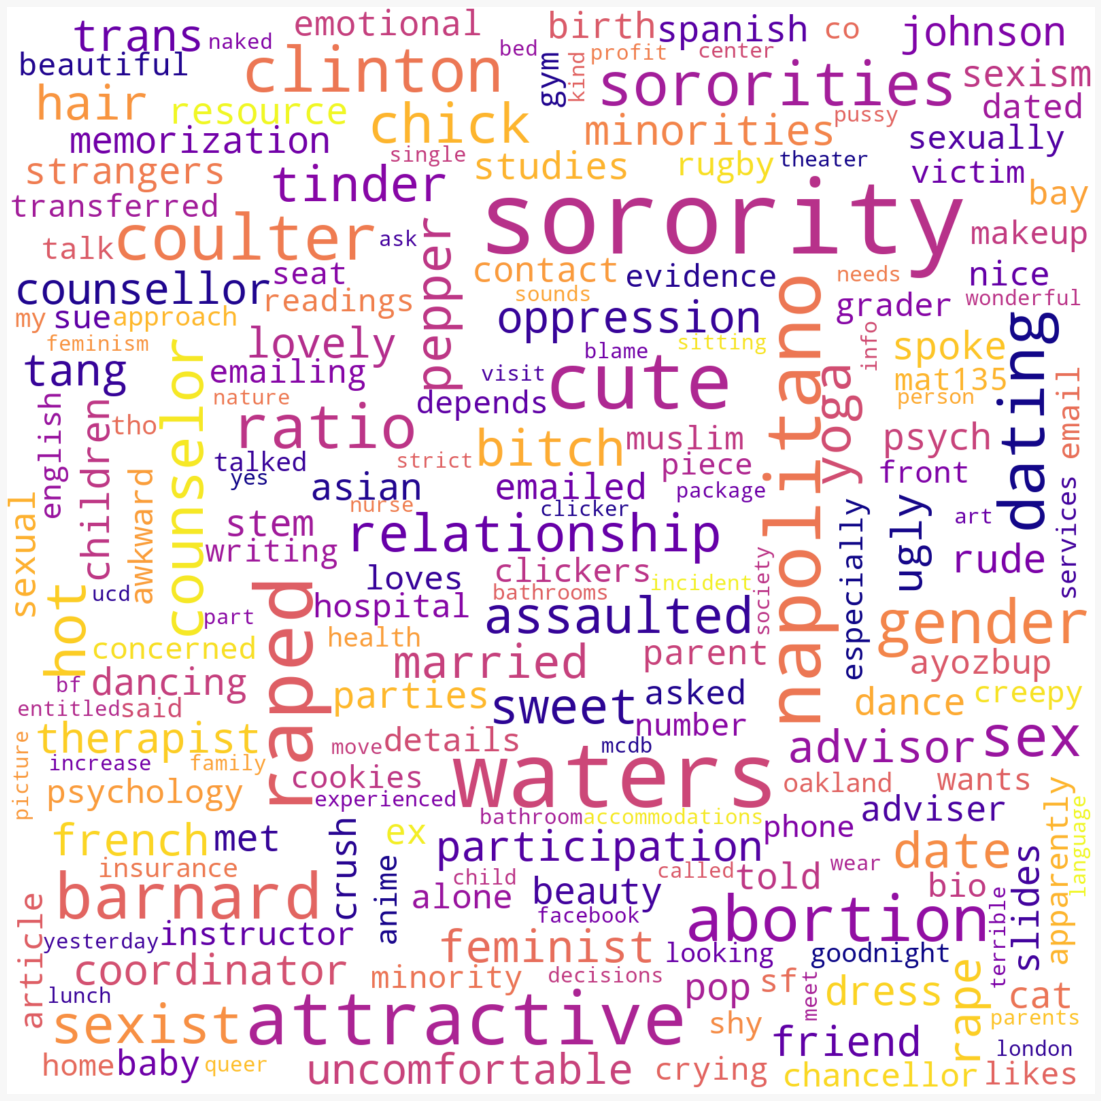

In [ ]:
plt.figure(figsize = (20, 20))
plt.imshow(cloud_fem, interpolation="bilinear")
plt.axis("off")

We create a word cloud of words that have the lowest coefficient values. These are words that have the highest predictive power of a comment being classified as male.

In [ ]:
word_data_mal = dict(zip(foo_w_coefficients_sorted_mal_sort["word"].tolist(), foo_w_coefficients_sorted_mal_sort["negative coefficients"].tolist()))
cloud_mal = WordCloud(max_words = 250, background_color = "white", width = 1600, height = 1600, max_font_size = 150, min_font_size = 30, colormap = "plasma").generate_from_frequencies(word_data_mal)

(-0.5, 1599.5, 1599.5, -0.5)

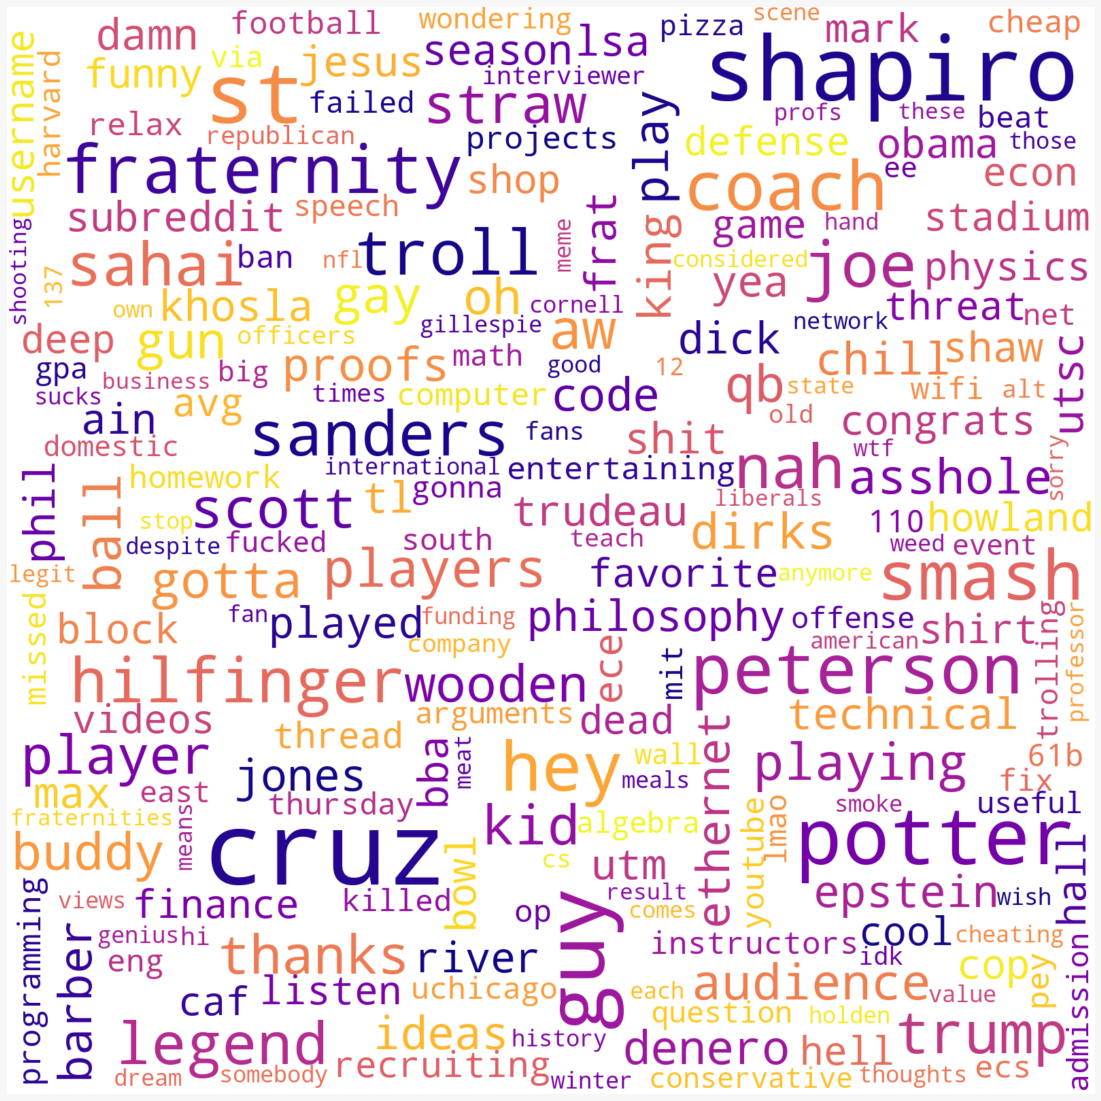

In [ ]:
plt.figure(figsize = (20, 20))
plt.imshow(cloud_mal, interpolation="bilinear")
plt.axis("off")

As does Wu (2018), we find the comments associated with the aforementioned predicted probabilities.

In [ ]:
train_one_class_w_y_pred = train_one_class.copy()
train_one_class_w_y_pred = train_one_class_w_y_pred.reset_index()
y_predicted_prob_post_fem_train_one_class_non_classifier_data = pd.DataFrame(y_predicted_prob_post_fem_train_one_class_non_classifier)
train_one_class_w_y_pred = pd.concat([train_one_class_w_y_pred, y_predicted_prob_post_fem_train_one_class_non_classifier_data], axis = 1)
train_one_class_w_y_pred = train_one_class_w_y_pred.rename(columns = {0: "y_predicted_prob_post_fem_class_non_classifier"})

In [ ]:
test_one_class_w_y_pred = test_one_class.copy()
test_one_class_w_y_pred = test_one_class_w_y_pred.reset_index()
y_predicted_prob_post_fem_test_one_class_non_classifier_data = pd.DataFrame(y_predicted_prob_post_fem_test_one_class_non_classifier)
test_one_class_w_y_pred = pd.concat([test_one_class_w_y_pred, y_predicted_prob_post_fem_test_one_class_non_classifier_data], axis = 1)
test_one_class_w_y_pred = test_one_class_w_y_pred.rename(columns = {0: "y_predicted_prob_post_fem_class_non_classifier"})

In [ ]:
test_both_class_w_y_pred = test_both_class.copy()
test_both_class_w_y_pred = test_both_class_w_y_pred.reset_index()
y_predicted_prob_post_fem_test_both_class_non_classifier_data = pd.DataFrame(y_predicted_prob_post_fem_test_both_class_non_classifier)
test_both_class_w_y_pred = pd.concat([test_both_class_w_y_pred, y_predicted_prob_post_fem_test_both_class_non_classifier_data], axis = 1)
test_both_class_w_y_pred = test_both_class_w_y_pred.rename(columns = {0: "y_predicted_prob_post_fem_class_non_classifier"})

We concatenate the above three dataframes along the axis of rows. This gives us a dataset of all the comments with gendered language and their associated predicted probabilities.

In [ ]:
uni_w_y_pred = pd.concat([train_one_class_w_y_pred, test_one_class_w_y_pred, test_both_class_w_y_pred])

We show the twenty five comments with the highest predicted probability of the post being classified as female. We notice discussions about sororities and Greek life emerge. This may primarily be due to the presence of the words "sister" and "sisters" in the female classifier list. We notice how sensitive our analysis is to "researchers' degrees of freedom". The prominent words that emerge in the word cloud above and the comments below are extremely sensitive to the words selected to be classifiers.

In [ ]:
pd.set_option('display.max_colwidth', -1)
uni_w_y_pred.sort_values("y_predicted_prob_post_fem_class_non_classifier", ascending = False).loc[:, ["comment_body", "subreddit", "y_predicted_prob_post_fem_class_non_classifier"]].head(25)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


comment_body  ... y_predicted_prob_post_fem_class_non_classifier
10947   this response includes the good and the bad, so it's probably not gonna please anyone, but here you go.\n\nfirst of all, you should know that this subreddit has many people who are "anti-greek", so keep in mind when reading the responses. in general, at ubc, there may be a negative stigma associated with the system. also, sororities are not that big compared to the states and only a small percentage of girls are involved in a sorority.\n\nsome people would say that sororities are incredibly toxic and that people in sororities are mostly "fake friends" and you have to spend a lot of money and time to partying, volunteering, meeting, etc. moreover, being in a sorority, or any organization, means that the bad behaviour of one person may be erroneously attributed to other members. also, sorority members have to dedicate a lot of time to supporting the sorority. and, yes, the financial cost is really high ($1000-$2000)....\n\nbut you get out what you put in. sororities are super rewarding and you get a lot out of being in one. don't let any of this discourage you from rushing a sorority. there may be two sororities that have a reputation of only select rich girls or hot girls, but otherwise sororities recruit all kinds of girls. sororities pick people based on the qualities they deem desirable; overall, they are quite welcoming as long as they think you would be a good fit. sororities are different from american counterparts; there is absolutely no hazing or harassing in sororities at ubc. ubc sororities focus a lot on sisterhood, friendship, and philanthropy... it really isn't about partying, unlike what most assume. there are awesome opportunities to network, volunteer and do philanthropy work through your sorority. also, there are opportunities for leadership roles in your sorority. members get a sorority sister who could be a really great friend and mentor.\n\nsororities do not have houses; however, they have the panhellenic house, where meetings are held and many sorority members live. there are also options to have leadership roles in panhellenic. moreover, many sorority members are often involved in other leadership positions at ubc, such as the ams.\n\ni highly recommend you to go through rush and see what it's all about. keep an open mind about all of the sororities and join one if you feel like it's best for you. it really depends on the kind of person you are. i can guarantee you that you will have new friends and connections by joining a sorority at ubc                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

We show the twenty five comments with the lowest predicted probability of the post being classified as female.

In [ ]:
uni_w_y_pred.sort_values("y_predicted_prob_post_fem_class_non_classifier", ascending = True).loc[:, ["comment_body", "subreddit", "y_predicted_prob_post_fem_class_non_classifier"]].head(25)

comment_body  ... y_predicted_prob_post_fem_class_non_classifier
119347  from the nfl website (i will try to change it to college rules when i notice the difference)\n\n\nbeginner's guide to football\n\none 11-man team has possession of the football. it is called the offense and it tries to advance the ball down the field-by running with the ball or throwing it - and score points by crossing the goal line and getting into an area called the end zone.\n\nthe other team (also with 11 players) is called the defense. it tries to stop the offensive team and make it give up possession of the ball. if the team with the ball does score or is forced to give up possession, the offensive and defensive teams switch roles (the offensive team goes on defense and the defensive team goes on offense). and so on, back and forth, until all four quarters of the game have been played.\n\nin order to make it easier to coordinate the information in this digest, the topics discussed generally follow the order of the rule book.\n\n\n\nthe field\n\nthe field measures 100 yards long and 53 yards wide. little white markings on the field called yard markers help the players, officials, and the fans keep track of the ball. probably the most important part of the field is the end zone. it's an additional 10 yards on each end of the field. this is where the points add up! when the offense - the team with possession of the ball-gets the ball into the opponent's end zone, they score points.\n\n\ntiming\n\ngames are divided into four 15-minute quarters, separated by a 12-minute break at halftime. there are also 2-minute breaks at the end of the first and third quarters as teams change ends of the field after every 15 minutes of play. at the end of the first and third quarters, the team with the ball retains possession heading into the following quarter. that is not the case before halftime. the second half starts with a kickoff in the same way as the game began in the first quarter.\n\neach offensive team has 40 seconds from the end of a given play until they must snap of the ball for the start of the next play, otherwise they will be penalized.\n\nthe clock stops at the end of incomplete passing plays, when a player goes out of bounds, or when a penalty is called. the clock starts again when the ball is re-spotted by an official.\n\nif a game is tied at the end of regulation, **college-  each period consists of one possession for each team, the order of which is decided by a pre-overtime coin toss. after each period, the order of possession flips.\n\neach drive starts at the defense's 25-yard line.\n\nif the teams remain tied at the end of a period, they play another. starting in the third period, teams can no longer kick extra points and must go for two after touchdowns**\n\n\nthe players\n\neach team has 3 separate units: the offense (see section below), those players who are on the field when the team has possession of the ball; the defense (see section below), players who line up to stop the other team's offense; and special teams that only come in on kicking situations (punts, field goals, and kickoffs). only 11 players are on the field from one team at any one time.\n\nto see how the players line up click here\nthe kickoff\n\na game starts with the kickoff. the ball is placed on a kicking tee at the defense's 30-yard line, and a special kicker (a "placekicker") kicks the ball to the offense a kick return man from the offense will try to catch the ball and advance it by running. where he is stopped is the point from which the offense will begin its drive, or series of offensive plays. when a kickoff is caught in the offense's own end zone, the kick returner can either run the ball out of the end zone, or kneel in the end zone to signal a touchback - a sign to stop the play. the ball is then placed on the 20-yard line, where the offense begins play.\nfirst down\n\nall progress in a football game is measured in yards. the offensive team tries to get as much

This analysis has taught us that in addition to our concerns outlined in the introduction, we need to be conscientious of the importance of the degrees of freedom available to researchers. We note the presence of last names in the word clouds. We chose not to include last names because for instance using the word "clinton" as a classifier for either female or male leads to ambiguity. The comment could have been referencing President William (Bill) Jefferson Clinton or Secretary Hillary Rodham Clinton. Initial drafts of our analysis included "joe" and "joes" as classifiers, but we soon learnt that this created bias leading to one of the largest words in the word cloud being "trader" as in grocery store chain "Trader Joe's". Initial drafts of our analysis also included the name "jose", but this created bias leading to the city of "San Jose" in California. 



## References

Wu, Alice H. 2018. "Gendered Language on the Economics Job Market Rumors Forum." AEA Papers and Proceedings, 108: 175-79.
DOI: 10.1257/pandp.20181101